In [2]:
import gzip
import random
import pandas as pd
import numpy as np
import json
import ast
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import string
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import scipy
# nltk.download('stopwords')

In [3]:
def MSE(pred, label):
    diff = [(x-y)**2 for (x,y) in zip(pred, label)]
    return sum(diff) / len(diff)

In [4]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    #feat.append(1) # offset
    return feat

In [5]:
# Read in the file
with open('runwayJ.json', 'r') as file :
    filedata = file.read()

# Replace the target string
filedata = filedata.replace('null', 'None')

# Write the file out again
with open('runwayJ.json', 'w') as file:
    file.write(filedata)

In [6]:
# Read in json
path = "runwayJ.json"
f = open(path)
data = []

for l in f:
    d = eval(l) 
    if d['rating'] != None: #remove missing values
        d['rating'] = int(d['rating']) #change rating to int
        data.append(d)
    
f.close()

In [7]:
len(data)

192462

In [8]:
split1 = int(len(data) * 0.7)
split2 = int(len(data) * 0.9)

In [9]:
train = data[:split1]
validation = data[split1:split2]
test = data[split2:]

## Bag of Words Ridge model

In [10]:
#Potential bag of words features without stopwords

stopwords_set = set(stopwords.words('english'))

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in train:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w not in stopwords_set:
            wordCount[w] += 1


In [11]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

In [12]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

X_train = scipy.sparse.lil_matrix((len(train), 1000))
for i in range(len(train)):
    X_train[i] = feature(train[i])
y_train = [d['rating'] for d in train]

X_val = scipy.sparse.lil_matrix((len(validation), 1000))
for i in range(len(validation)):
    X_val[i] = feature(validation[i])
y_val = [d['rating'] for d in validation]

X_test = scipy.sparse.lil_matrix((len(test), 1000))
for i in range(len(test)):
    X_test[i] = feature(test[i])
y_test = [d['rating'] for d in test]

In [13]:
mod = linear_model.Ridge(1) # dont need fit_intercept=False bc we didnt manually add offset term
mod.fit(X_train, y_train)
theta = mod.coef_
val_predictions = mod.predict(X_val)

In [14]:
MSE(val_predictions, y_val)

1.5341931059640286

In [15]:
MSE(mod.predict(X_test), y_test)

1.5344694924363182

In [16]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()
wordSort[:20]

[(-1.166716807445799, 'unflattering'),
 (-0.7516728266352667, 'unfortunately'),
 (-0.7290066099768828, 'odd'),
 (-0.726165148455739, 'disappointed'),
 (-0.6736008081354841, 'excited'),
 (-0.6628003307065135, 'awkward'),
 (-0.6432149794255907, 'returned'),
 (-0.6273594578643606, 'stars'),
 (-0.6241380910338162, 'boxy'),
 (-0.45037026419326237, 'constantly'),
 (-0.4185535604388244, 'baggy'),
 (-0.3988835520543935, 'huge'),
 (-0.3844938130112188, 'weird'),
 (-0.35469539736215067, 'least'),
 (-0.339164183210792, 'ok'),
 (-0.337104801817933, 'end'),
 (-0.33093514273237895, 'hung'),
 (-0.3187476482926431, 'except'),
 (-0.28928201081896776, 'okay'),
 (-0.28652957288656317, 'unless')]

## fastFM latent factor model - won't run on datahub

In [17]:
from fastFM import als
# populate utility dictionaries
userIDs = {}
itemIDs = {}
interactions = []
interactionsPerUser = defaultdict(list)

for d in data:
    u = d['user_id']
    i = d['item_id']
    if u not in userIDs: userIDs[u] = len(userIDs)
    if i not in itemIDs: itemIDs[i] = len(itemIDs)

nUser, nItem = len(userIDs), len(itemIDs)

In [ ]:
X_train = scipy.sparse.lil_matrix((len(train), nUser + nItem))
for r in range(len(train)):
    u, i = userIDs[train[r]['user_id']], itemIDs[train[r]['item_id']]
    X_train[r, u] = 1
    X_train[r, nUser + i] = 1

X_val = scipy.sparse.lil_matrix((len(validation), nUser + nItem))
for r in range(len(validation)):
    u, i = userIDs[validation[r]['user_id']], itemIDs[validation[r]['item_id']]
    X_val[r, u] = 1
    X_val[r, nUser + i] = 1
    
X_test = scipy.sparse.lil_matrix((len(test), nUser + nItem))
for r in range(len(test)):
    u, i = userIDs[test[r]['user_id']], itemIDs[test[r]['item_id']]
    X_test[r, u] = 1
    X_test[r, nUser + i] = 1
    
y_train = [d['rating'] for d in train]
y_val = [d['rating'] for d in validation]
y_test = [d['rating'] for d in test]

In [ ]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)

fm.fit(X_train, y_train)
val_pred = fm.predict(X_val)
test_pred = fm.predict(X_test)
valMSE = MSE(val_pred, y_val)
testMSE = MSE(test_pred, y_test)

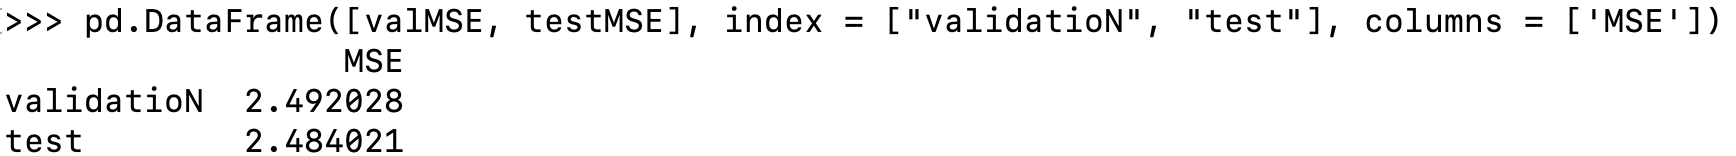

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "fastFM.png"
Image(filename = PATH, width=800, height=500)

## Dataset Exploration

In [86]:
ratings = [i['rating'] for i in data]

In [87]:
print(np.mean(ratings), np.std(ratings))

9.092371481123546 1.4300404687885462


In [72]:
tester = pd.DataFrame(data)

In [85]:
def year(date):
    return date[-4:]
tester['review_date'].apply(year).value_counts()

2017    67871
2016    51361
2015    30596
2014    28269
2013     9617
2012     3302
2018     1255
2011      190
2010        1
Name: review_date, dtype: int64

In [88]:
tester.describe() #describe table

,rating,size
count,192462.000000,192462.000000
mean,9.092371,12.245254
std,1.430044,8.495463
min,2.000000,0.000000
25%,8.000000,8.000000
50%,10.000000,12.000000
75%,10.000000,16.000000
max,10.000000,58.000000


In [91]:
tester.isna().apply(sum, axis = 0) #Missingness summary

fit                   0
user_id               0
bust size         18397
item_id               0
weight            29957
rating                0
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 959
review_date           0
dtype: int64

In [104]:
tester['rented for'].value_counts() #rented reasons table

wedding            57768
formal affair      40365
party              35613
everyday           16822
other              15381
work               15042
date                7387
vacation            4073
party: cocktail        1
Name: rented for, dtype: int64